In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, '../scripts/')
from utils import *
from processing import *
import pickle
from hyperopt import tpe, fmin, hp
from hyperopt.pyll.base import scope
from sklearn.decomposition import PCA
import shap
import torch
from torch import nn 
import torch.nn.functional as F
from skorch import NeuralNetClassifier

In [2]:
lead = 0
obs = 1

In [12]:
# Original data
data = pd.read_csv("../csv/relative_{}hr_lead_{}hr_obs_data/relative_{}hr_lead_{}hr_obs_dataset_no_pts.csv".format(lead, obs, lead, obs), low_memory=False)
data["mv_duration_ratio"] = data["mv_duration"]/data["LOS"]

data = process_all(data)
for col in data.columns:
    if missing_data(data, col)[0] > 0.2*missing_data(data,col)[1]:
        data.drop(labels=[col], axis=1, inplace=True)

common_imputation= ["Gender", "UrgentAdmission", "TeachingStatus"]
for col in data.columns:
    if col.startswith("comorbidity_") or col.startswith("Hist"):
        common_imputation.append(col)
one_hot_removal = []
remove = ["APACHEIVaScore", "relative_{}hr_lead_{}hr_obsHaloperidol".format(lead, obs), "relative_{}hr_lead_{}hr_obsPrecedex".format(lead, obs), "ventilator", "UnitAdmitSource_Missing", "vasopressors"]#, "mean_motor_GCS", 

exceptions = []# ["UrgentAdmission"]

mean_imputation = data.columns
mean_imputation = mean_imputation.drop(common_imputation)
mean_imputation = mean_imputation.drop(one_hot_removal)
mean_imputation = mean_imputation.drop(remove)
mean_imputation = mean_imputation.drop(exceptions)
mean_imputation = mean_imputation.tolist()


for col in data.columns:
    if col.startswith("count_"):
        data[col] = data[col].fillna(0)
    if col.startswith("diff_"):
        data[col] = data[col].fillna(0)

from sklearn.impute import SimpleImputer
data.drop(remove, axis=1, inplace = True)
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(data[mean_imputation])
data[mean_imputation] = imp_mean.transform(data[mean_imputation])
imp_freq = SimpleImputer(strategy='most_frequent')
imp_freq.fit(data[common_imputation])
data[common_imputation] = imp_freq.transform(data[common_imputation])
data.dropna(inplace = True)
data

,PatientStayID,Class,LOS,Age,APACHEIVscore,UrgentAdmission,NumBeds,TeachingStatus,Gender,AdmitHeight,...,UnitAdmitSource_DirectAdmit,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,UnitAdmitSource_PACU,UnitAdmitSource_SDU,TimeOfDay
0,150934.0,1.0,826.0,69.0,78.0,1.0,2.0,0.0,1.0,152.4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6060.0
1,151708.0,1.0,2007.0,79.0,38.0,1.0,4.0,1.0,0.0,175.3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13680.0
2,152171.0,1.0,2380.0,84.0,38.0,0.0,2.0,0.0,1.0,165.1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25320.0
3,155126.0,1.0,3521.0,71.0,65.0,0.0,4.0,1.0,0.0,165.1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,79860.0
4,156970.0,1.0,17999.0,56.0,32.0,1.0,4.0,1.0,0.0,167.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28620.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22373,3352487.0,0.0,720.0,60.0,45.0,0.0,4.0,0.0,1.0,168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,48780.0
22374,3352563.0,0.0,923.0,34.0,54.0,1.0,2.0,0.0,1.0,172.7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,540.0
22375,3352747.0,0.0,1006.0,30.0,31.0,1.0,4.0,0.0,0.0,167.6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32400.0
22376,3353044.0,0.0,3398.0,52.0,41.0,1.0,2.0,0.0,0.0,175.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,22620.0


In [13]:
over_time = pd.read_csv("../csv/over_time/over_time_dataset_no_pts.csv", low_memory=False)
over_time["mv_duration_ratio"] = over_time["mv_duration"]/over_time["LOS"]
over_time = process_all(over_time)

for col in over_time:
    if "DrugOverTime_" in col:
        over_time.rename(columns={col : col.replace("DrugOverTime_", "relative_{}hr_lead_{}hr_obs".format(lead, obs))}, inplace=True)
over_time

,PatientStayID,start,Class,del_start,total_LOS,LOS,Age,APACHEIVscore,APACHEIVaScore,UrgentAdmission,...,UnitAdmitTimeInt,UnitAdmitSource_DirectAdmit,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_Missing,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,TimeOfDay
0,3104736,0,1,6683.0,7020,60,67.0,68.0,68.0,0.0,...,74220,0,0,0,0,0,0,1,0,43020
1,3104736,60,1,6683.0,7020,120,67.0,68.0,68.0,0.0,...,74220,0,0,0,0,0,0,1,0,46620
2,3104736,120,1,6683.0,7020,180,67.0,68.0,68.0,0.0,...,74220,0,0,0,0,0,0,1,0,50220
3,3104736,180,1,6683.0,7020,240,67.0,68.0,68.0,0.0,...,74220,0,0,0,0,0,0,1,0,53820
4,3104736,240,1,6683.0,7020,300,67.0,68.0,68.0,0.0,...,74220,0,0,0,0,0,0,1,0,57420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4755,1711348,540,1,874.0,4204,600,90.0,NaN,NaN,0.0,...,78720,0,0,0,1,0,0,0,0,15300
4756,1711348,600,1,874.0,4204,660,90.0,NaN,NaN,0.0,...,78720,0,0,0,1,0,0,0,0,18900
4757,1711348,660,1,874.0,4204,720,90.0,NaN,NaN,0.0,...,78720,0,0,0,1,0,0,0,0,22500
4758,1711348,720,1,874.0,4204,780,90.0,NaN,NaN,0.0,...,78720,0,0,0,1,0,0,0,0,26100


In [14]:
# Mismatch in Features, features in original that aren't in validation
for col in data.columns:
    if col not in over_time.columns:
        print(col)
        over_time[col] = np.nan

Trauma
UnitAdmitSource_PACU
UnitAdmitSource_SDU


In [15]:
# Mismatch in Features, features in validation that aren't in original
for col in (over_time.iloc[:, 5:]).columns:
    if col not in data.columns:
        print(col)
        over_time.drop(columns=[col], inplace=True)

APACHEIVaScore
relative_0hr_lead_1hr_obsHaloperidol
relative_0hr_lead_1hr_obsPrecedex
last_albumin
diff_albumin
last_alkaline phos.
diff_alkaline phos.
last_ALT (SGPT)
diff_ALT (SGPT)
last_anion gap
diff_anion gap
last_AST (SGOT)
diff_AST (SGOT)
last_bedside glucose
diff_bedside glucose
last_BUN
diff_BUN
last_calcium
diff_calcium
last_chloride
diff_chloride
last_creatinine
diff_creatinine
last_FiO2
diff_FiO2
last_glucose
diff_glucose
last_Hct
diff_Hct
last_Hgb
diff_Hgb
last_lactate
diff_lactate
last_-lymphs
diff_-lymphs
last_magnesium
diff_magnesium
last_MCH
diff_MCH
last_MCHC
diff_MCHC
last_MCV
diff_MCV
last_-monos
diff_-monos
last_MPV
diff_MPV
last_O2 Sat (%)
diff_O2 Sat (%)
last_paCO2
diff_paCO2
last_paO2
diff_paO2
last_pH
diff_pH
last_phosphate
diff_phosphate
last_platelets x 1000
diff_platelets x 1000
last_-polys
diff_-polys
last_potassium
diff_potassium
last_PT
diff_PT
last_PT - INR
diff_PT - INR
last_RBC
diff_RBC
last_RDW
diff_RDW
last_sodium
diff_sodium
last_total bilirubin
dif

In [16]:
over_time.iloc[:, 5:] = over_time[data.iloc[:, 2:].columns]

over_time[mean_imputation] = imp_mean.transform(over_time[mean_imputation])
over_time[common_imputation] = imp_freq.transform(over_time[common_imputation])

labels = data['Class']
data.drop(['Class'], axis=1, inplace=True)

# validation_labels = validation['Class']
# validation.drop(['Class'], axis=1, inplace=True)

with open("../pickle/relative_{}hr_lead_{}hr_obs/mean_unpruned/lr_calibrated_dropped_feats.pkl".format(lead, obs), "rb") as f:
	dropped_feat = pickle.load(f)


data_pruned = data.drop(dropped_feat, axis=1, errors='ignore')
over_time_pruned = over_time.drop(dropped_feat, axis=1, errors='ignore')

In [17]:
data

,PatientStayID,LOS,Age,APACHEIVscore,UrgentAdmission,NumBeds,TeachingStatus,Gender,AdmitHeight,AdmitWeight,...,UnitAdmitSource_DirectAdmit,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,UnitAdmitSource_PACU,UnitAdmitSource_SDU,TimeOfDay
0,150934.0,826.0,69.0,78.0,1.0,2.0,0.0,1.0,152.4,74.800000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6060.0
1,151708.0,2007.0,79.0,38.0,1.0,4.0,1.0,0.0,175.3,70.800000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13680.0
2,152171.0,2380.0,84.0,38.0,0.0,2.0,0.0,1.0,165.1,84.184547,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25320.0
3,155126.0,3521.0,71.0,65.0,0.0,4.0,1.0,0.0,165.1,83.200000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,79860.0
4,156970.0,17999.0,56.0,32.0,1.0,4.0,1.0,0.0,167.6,90.500000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28620.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22373,3352487.0,720.0,60.0,45.0,0.0,4.0,0.0,1.0,168.0,118.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,48780.0
22374,3352563.0,923.0,34.0,54.0,1.0,2.0,0.0,1.0,172.7,81.600000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,540.0
22375,3352747.0,1006.0,30.0,31.0,1.0,4.0,0.0,0.0,167.6,62.600000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32400.0
22376,3353044.0,3398.0,52.0,41.0,1.0,2.0,0.0,0.0,175.0,52.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,22620.0


In [18]:
over_time

,PatientStayID,start,Class,del_start,total_LOS,LOS,Age,APACHEIVscore,UrgentAdmission,NumBeds,...,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,TimeOfDay,Trauma,UnitAdmitSource_PACU,UnitAdmitSource_SDU
0,3104736.0,0,1.0,6683.0,7020,60.0,67.0,68.000000,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,43020.0,0.024086,0.071454,0.0513
1,3104736.0,60,1.0,6683.0,7020,120.0,67.0,68.000000,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,46620.0,0.024086,0.071454,0.0513
2,3104736.0,120,1.0,6683.0,7020,180.0,67.0,68.000000,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,50220.0,0.024086,0.071454,0.0513
3,3104736.0,180,1.0,6683.0,7020,240.0,67.0,68.000000,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,53820.0,0.024086,0.071454,0.0513
4,3104736.0,240,1.0,6683.0,7020,300.0,67.0,68.000000,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,57420.0,0.024086,0.071454,0.0513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4755,1711348.0,540,1.0,874.0,4204,600.0,90.0,56.290423,0.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,15300.0,0.024086,0.071454,0.0513
4756,1711348.0,600,1.0,874.0,4204,660.0,90.0,56.290423,0.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,18900.0,0.024086,0.071454,0.0513
4757,1711348.0,660,1.0,874.0,4204,720.0,90.0,56.290423,0.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,22500.0,0.024086,0.071454,0.0513
4758,1711348.0,720,1.0,874.0,4204,780.0,90.0,56.290423,0.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,26100.0,0.024086,0.071454,0.0513


In [19]:
over_time["PatientStayID"].unique()

array([3104736., 1064617., 3333061., 1240168., 1695980., 1071828.,
        972672., 1006632., 1014189., 1548224., 3037970., 1069622.,
       2239717., 1024588., 3082618., 2908572., 1614095.,  975176.,
        960455.,  576281., 3173403.,  293455.,  959525., 1002484.,
       1478582.,  504981., 1010953.,  531063.,  287879.,  979584.,
        976938., 1657412.,  590978.,  503782., 1711309., 1438234.,
       1073583., 3107073.,  964381., 1686420.,  978325., 2871963.,
       1153171., 1619035., 1000643., 1475099., 1652092., 3036491.,
       1057428., 1711348.])

In [20]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(**{"n_estimators": 3000})
clf.fit(data.iloc[:, 1:], labels)

Learning rate set to 0.014184
0:	learn: 0.6749485	total: 186ms	remaining: 9m 17s
1:	learn: 0.6534194	total: 209ms	remaining: 5m 13s
2:	learn: 0.6338063	total: 241ms	remaining: 4m
3:	learn: 0.6166765	total: 288ms	remaining: 3m 35s
4:	learn: 0.5996914	total: 336ms	remaining: 3m 21s
5:	learn: 0.5864838	total: 364ms	remaining: 3m 1s
6:	learn: 0.5740734	total: 431ms	remaining: 3m 4s
7:	learn: 0.5628369	total: 453ms	remaining: 2m 49s
8:	learn: 0.5474671	total: 473ms	remaining: 2m 37s
9:	learn: 0.5333002	total: 519ms	remaining: 2m 35s
10:	learn: 0.5196054	total: 536ms	remaining: 2m 25s
11:	learn: 0.5078665	total: 566ms	remaining: 2m 20s
12:	learn: 0.4958923	total: 599ms	remaining: 2m 17s
13:	learn: 0.4871187	total: 646ms	remaining: 2m 17s
14:	learn: 0.4790060	total: 699ms	remaining: 2m 19s
15:	learn: 0.4713236	total: 724ms	remaining: 2m 15s
16:	learn: 0.4622398	total: 751ms	remaining: 2m 11s
17:	learn: 0.4530027	total: 803ms	remaining: 2m 13s
18:	learn: 0.4443236	total: 847ms	remaining: 2m 12

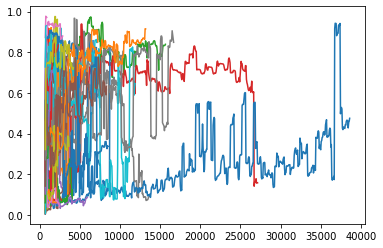

In [21]:
plt.figure()

for patidIndex, patid in enumerate(over_time["PatientStayID"].unique()):
    time_points = []
    predicted_probability = []

    predicted_probability = clf.predict_proba(over_time[(over_time["PatientStayID"] == patid) & (over_time["LOS"] >= 12*60)].iloc[:, 5:])
    plt.plot(over_time[(over_time["PatientStayID"] == patid) & (over_time["LOS"] >= 12*60)].loc[:, ["LOS"]], predicted_probability[:, 1])
    

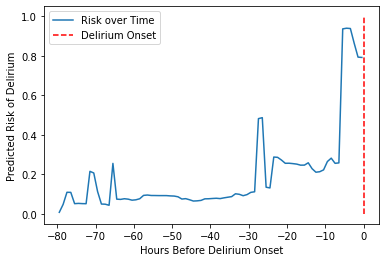

In [41]:
plt.figure()

patid = over_time["PatientStayID"].unique()[13]

time_points = []
predicted_probability = []
delirium_onset_time = over_time[(over_time["PatientStayID"] == patid)].iloc[0, 3]/60

predicted_probability = clf.predict_proba(over_time[(over_time["PatientStayID"] == patid) & (over_time["LOS"] >= 12*60)].iloc[:, 5:])
plt.plot(-delirium_onset_time + over_time[(over_time["PatientStayID"] == patid) & (over_time["LOS"] >= 12*60)].loc[:, ["LOS"]]/60, predicted_probability[:, 1])
plt.plot([0, 0], [0, 1], 'r--')
plt.xlabel("Hours Before Delirium Onset")
plt.ylabel("Predicted Risk of Delirium")
plt.legend(["Risk over Time", "Delirium Onset"])
plt.savefig("../figures/over_time/relative_{}hr_lead{}hr_obs_over_time_positive.png".format(lead, obs))
plt.show()

In [50]:
over_time["PatientStayID"] == patid

0        True
1        True
2        True
3        True
4        True
        ...  
4755    False
4756    False
4757    False
4758    False
4759    False
Name: PatientStayID, Length: 4760, dtype: bool